In [102]:
import pandas as pd
import numpy as np
import os
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from scipy import stats
from ast import literal_eval
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.metrics.pairwise import linear_kernel, cosine_similarity
from nltk.stem.snowball import SnowballStemmer
from nltk.stem.wordnet import WordNetLemmatizer
from nltk.corpus import wordnet

import warnings; warnings.simplefilter('ignore')
from sklearn.model_selection import GridSearchCV

In [62]:
column = ['UserID', 'productId', 'ratings','timestamp']
df_rec = pd.read_csv("ratings_Electronics.csv", names = ['UserID', 'productId', 'ratings','timestamp'])
df_rec=df_rec.drop(columns=['timestamp'])
df_rec.head()

,UserID,productId,ratings
0,AKM1MP6P0OYPR,0132793040,5.0
1,A2CX7LUOHB2NDG,0321732944,5.0
2,A2NWSAGRHCP8N5,0439886341,1.0
3,A2WNBOD3WNDNKT,0439886341,3.0
4,A1GI0U4ZRJA8WN,0439886341,1.0


1. Read and explore the dataset. (Rename column, plot histograms, find data characteristics)

In [65]:
df_rec.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7824482 entries, 0 to 7824481
Data columns (total 3 columns):
UserID       object
productId    object
ratings      float64
dtypes: float64(1), object(2)
memory usage: 179.1+ MB


In [66]:
df_rec.isna().sum()

UserID       0
productId    0
ratings      0
dtype: int64

In [67]:
df_rec = df_rec.rename(columns = {"UserID": "user_id", "productId": "prod_id", "ratings": "rating"})

In [68]:
df_rec.head()

,user_id,prod_id,rating
0,AKM1MP6P0OYPR,0132793040,5.0
1,A2CX7LUOHB2NDG,0321732944,5.0
2,A2NWSAGRHCP8N5,0439886341,1.0
3,A2WNBOD3WNDNKT,0439886341,3.0
4,A1GI0U4ZRJA8WN,0439886341,1.0


In [69]:
#df_rec.prod_id = df_rec.prod_id.astype('int')

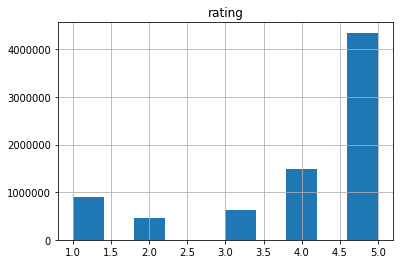

In [70]:
hist = df_rec.hist()

In [71]:
df_rec.describe().T

,count,mean,std,min,25%,50%,75%,max
rating,7824482.0,4.012337,1.38091,1.0,3.0,5.0,5.0,5.0


In [72]:
df_rec.isnull().sum()

user_id    0
prod_id    0
rating     0
dtype: int64

0 missing values across columns so no need to do missing value treatment.

In [73]:
df_rec.shape

(7824482, 3)

In [93]:
user =df_rec["user_id"].unique()
len(user)

4201696

In [94]:
from itertools import chain

numeric_cols = df_rec.select_dtypes(include=['float64', 'int64']).columns

outlier_rec = []
# For each predictors find outliers using mathematical function.
def find_outlier(df_in, col_name, verbose=False):
    q25 = df_in[col_name].quantile(0.25)
    q75 = df_in[col_name].quantile(0.75)
    iqr = q75-q25 #Interquartile range
    lower, upper  = q25-1.5*iqr, q75+1.5*iqr
    outliers_df = df_in[(df_in[col_name] < lower) | (df_in[col_name] > upper)]
    outliers_removed_df = df_in[(df_in[col_name] >= lower) & (df_in[col_name] <= upper)]
    
    if(verbose):
        print('Number of outliers / non-outliers for column \'{}\': {} /{}'.format(
            col_name, outliers_df.shape[0], outliers_removed_df.shape[0]))
    return outliers_df.index.tolist();

for feature in numeric_cols:
    outlier_rec.append(find_outlier(df_rec, feature, True))
    
outlier_rec = list(chain.from_iterable(outlier_rec))
outlier_rec = list(set(outlier_rec)) 
outlier_rec.sort()
print('Total outliers in the dataset: {}'.format(len(outlier_rec)))
print(outlier_rec)

Number of outliers / non-outliers for column 'rating': 0 /7824482
Total outliers in the dataset: 0
[]


No outlier so no need to do outlier treatment

In [98]:
top_rated = df_rec.groupby('user_id').size().sort_values(ascending=False)
top_rated.head()

user_id
A5JLAU2ARJ0BO     520
ADLVFFE4VBT8      501
A3OXHLG6DIBRW8    498
A6FIAB28IS79      431
A680RUE1FDO8B     406
dtype: int64

In [99]:
counts = df_rec['user_id'].value_counts()
df_rec_new = df_rec[df_rec['user_id'].isin(counts[counts >= 50].index)]

In [100]:
df_rec_new.shape

(125871, 3)

In [103]:
ratings_count = df_rec_new.groupby(['user_id']).agg({'rating': 'count'}).reset_index()
grouped_sum = ratings_count['rating'].sum()
ratings_count['percentage']  = ratings_count['rating'].div(grouped_sum)*100
ratings_count.sort_values(['rating', 'user_id'], ascending = [0,1])

,user_id,rating,percentage
1203,A5JLAU2ARJ0BO,520,0.413121
1287,ADLVFFE4VBT8,501,0.398027
1086,A3OXHLG6DIBRW8,498,0.395643
1210,A6FIAB28IS79,431,0.342414
1209,A680RUE1FDO8B,406,0.322552
264,A1ODOGXEYECQQ8,380,0.301896
903,A36K2N527TXXJN,314,0.249462
521,A2AY4YUOX2N1BQ,311,0.247078
1508,AWPODHOB4GFWL,308,0.244695
462,A25C2M3QF9G7OQ,296,0.235161


3. Split the data randomly into train and test dataset.

In [104]:
from sklearn.model_selection import train_test_split
train_data, test_data = train_test_split(df_rec_new, test_size = 0.30, random_state=0)

In [105]:
print(train_data.head(5))

                user_id     prod_id  rating
6595853  A2BYV7S1QP2YIG  B009EAHVTA     5.0
4738241   AB094YABX21WQ  B0056XCEAA     1.0
4175596  A3D0UM4ZD2CMAW  B004I763AW     5.0
3753016   AATWFX0ZZSE6C  B0040NPHMO     3.0
1734767  A1NNMOD9H36Q8E  B0015VW3BM     4.0


In [106]:
train_data_grouped = train_data.groupby('prod_id').mean().reset_index()
train_data_sort = train_data_grouped.sort_values(['rating', 'prod_id'], ascending = [0,1])

4. Build Popularity Recommender model.

In [107]:
#Count of user_id for each unique product as recommendation score 
train_data_grouped = train_data.groupby('prod_id').agg({'user_id': 'count'}).reset_index()
train_data_grouped.rename(columns = {'user_id': 'score'},inplace=True)
train_data_grouped.head()

,prod_id,score
0,0594451647,1
1,0594481813,1
2,0970407998,1
3,0972683275,3
4,1400501466,4


In [108]:
#Sort the products
train_data_sort = train_data_grouped.sort_values(['score', 'prod_id'], ascending = [0,1])

In [110]:
#Rank the product based on score
train_data_sort['Rank'] = train_data_sort['score'].rank(ascending=0, method='first') 

In [111]:
#Top 5 recommendation
popularity_recommendations = train_data_sort.head() 
popularity_recommendations

,prod_id,score,Rank
30847,B0088CJT4U,133,1.0
30287,B007WTAJTO,124,2.0
19647,B003ES5ZUU,122,3.0
8752,B000N99BBC,114,4.0
30555,B00829THK0,97,5.0


Use popularity based recommender model to make predictions

In [112]:

def recommend(user_id):     
    user_recommendations = popularity_recommendations 
          
    #Add user_id column for which the recommendations are being generated 
    user_recommendations['user_id'] = user_id 
      
    #Bring user_id column to the front 
    cols = user_recommendations.columns.tolist() 
    cols = cols[-1:] + cols[:-1] 
    user_recommendations = user_recommendations[cols] 
          
    return user_recommendations

In [115]:
find_recom = [1,71,500,1150,5]   # This list is user choice.
for i in find_recom:
    print("Recommendation for the user: %d\n" %(i))
    print(recommend(i),"\n")  

Recommendation for the user: 1

       user_id     prod_id  score  Rank
30847        1  B0088CJT4U    133   1.0
30287        1  B007WTAJTO    124   2.0
19647        1  B003ES5ZUU    122   3.0
8752         1  B000N99BBC    114   4.0
30555        1  B00829THK0     97   5.0 

Recommendation for the user: 71

       user_id     prod_id  score  Rank
30847       71  B0088CJT4U    133   1.0
30287       71  B007WTAJTO    124   2.0
19647       71  B003ES5ZUU    122   3.0
8752        71  B000N99BBC    114   4.0
30555       71  B00829THK0     97   5.0 

Recommendation for the user: 500

       user_id     prod_id  score  Rank
30847      500  B0088CJT4U    133   1.0
30287      500  B007WTAJTO    124   2.0
19647      500  B003ES5ZUU    122   3.0
8752       500  B000N99BBC    114   4.0
30555      500  B00829THK0     97   5.0 

Recommendation for the user: 1150

       user_id     prod_id  score  Rank
30847     1150  B0088CJT4U    133   1.0
30287     1150  B007WTAJTO    124   2.0
19647     1150  B003

5. Build Collaborative Filtering model.

In [116]:
from surprise import Reader, Dataset, SVD, evaluate,accuracy,GridSearch
from surprise.model_selection import GridSearchCV
from surprise.accuracy import rmse
from surprise import dump
from collections import defaultdict
from surprise.model_selection import train_test_split

In [118]:
df_cf = df_rec_new

In [120]:
#User based Collaborative filtering
pivot_df = df_cf.pivot(index = 'user_id', columns ='prod_id', values = 'rating').fillna(0)
print(pivot_df.shape)
pivot_df.head()

(1540, 48190)


prod_id,0594451647,0594481813,0970407998,0972683275,1400501466,1400501520,1400501776,1400532620,1400532655,140053271X,...,B00L5YZCCG,B00L8I6SFY,B00L8QCVL6,B00LA6T0LS,B00LBZ1Z7K,B00LED02VY,B00LGN7Y3G,B00LGQ6HL8,B00LI4ZZO8,B00LKG1MC8
user_id,,,,,,,,,,,,,,,,,,,,,
A100UD67AHFODS,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
A100WO06OQR8BQ,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
A105S56ODHGJEK,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
A105TOJ6LTVMBG,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
A10AFVU66A79Y1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [122]:
pivot_df['user_index'] = np.arange(0, pivot_df.shape[0], 1)
pivot_df.head()

prod_id,0594451647,0594481813,0970407998,0972683275,1400501466,1400501520,1400501776,1400532620,1400532655,140053271X,...,B00L8I6SFY,B00L8QCVL6,B00LA6T0LS,B00LBZ1Z7K,B00LED02VY,B00LGN7Y3G,B00LGQ6HL8,B00LI4ZZO8,B00LKG1MC8,user_index
user_id,,,,,,,,,,,,,,,,,,,,,
A100UD67AHFODS,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
A100WO06OQR8BQ,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1
A105S56ODHGJEK,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2
A105TOJ6LTVMBG,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3
A10AFVU66A79Y1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4


In [123]:
pivot_df.set_index(['user_index'], inplace=True)
# Actual ratings
pivot_df.head()

prod_id,0594451647,0594481813,0970407998,0972683275,1400501466,1400501520,1400501776,1400532620,1400532655,140053271X,...,B00L5YZCCG,B00L8I6SFY,B00L8QCVL6,B00LA6T0LS,B00LBZ1Z7K,B00LED02VY,B00LGN7Y3G,B00LGQ6HL8,B00LI4ZZO8,B00LKG1MC8
user_index,,,,,,,,,,,,,,,,,,,,,
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


SVD Method (Used in Collaborative filtering)

In [137]:
from scipy.sparse.linalg import svds
# SVD
U, sigma, Vt = svds(pivot_df, k = 50)
# Diagonal array in SVD
sigma = np.diag(sigma)


In [125]:
all_user_predicted_ratings = np.dot(np.dot(U, sigma), Vt) 

# Predicted ratings
preds_df = pd.DataFrame(all_user_predicted_ratings, columns = pivot_df.columns)
preds_df.head()

prod_id,0594451647,0594481813,0970407998,0972683275,1400501466,1400501520,1400501776,1400532620,1400532655,140053271X,...,B00L5YZCCG,B00L8I6SFY,B00L8QCVL6,B00LA6T0LS,B00LBZ1Z7K,B00LED02VY,B00LGN7Y3G,B00LGQ6HL8,B00LI4ZZO8,B00LKG1MC8
0,0.005086,0.002178,0.003668,-0.040843,0.009640,0.006808,0.020659,0.000649,0.020331,0.005633,...,0.000238,-0.061477,0.001214,-0.123433,0.028490,0.016109,0.002855,-0.174568,0.011367,-0.012997
1,0.002286,-0.010898,-0.000724,0.130259,0.007506,-0.003350,0.063711,-0.000674,0.016111,-0.002433,...,-0.000038,0.013766,0.001473,0.025588,-0.042103,0.004251,0.002177,-0.024362,-0.014765,0.038570
2,-0.001655,-0.002675,-0.007355,0.007264,0.005152,-0.003986,-0.003480,0.006961,-0.006606,-0.002719,...,-0.001708,-0.051040,0.000325,-0.054867,0.017870,-0.004996,-0.002426,0.083928,-0.112205,0.005964
3,0.001856,0.011019,-0.005910,-0.014134,0.000179,0.001877,-0.005391,-0.001709,0.004968,0.001402,...,0.000582,-0.009326,-0.000465,-0.048315,0.023302,0.006790,0.003380,0.005460,-0.015263,-0.025996
4,0.001115,-0.002670,0.011018,0.014434,0.010319,0.006002,0.017151,0.003726,0.001404,0.005645,...,0.000207,0.023761,0.000747,-0.019347,-0.012749,0.001026,0.001364,-0.020580,0.011828,0.012770


In [126]:
#Recommend the product based on predictive ratings


def recommend_items(userID, pivot_df, preds_df, num_recommendations):
      
    user_idx = userID-1 # index starts at 0
    
    # Get and sort the user's ratings
    sorted_user_ratings = pivot_df.iloc[user_idx].sort_values(ascending=False)
    #sorted_user_ratings
    sorted_user_predictions = preds_df.iloc[user_idx].sort_values(ascending=False)
    #sorted_user_predictions

    temp = pd.concat([sorted_user_ratings, sorted_user_predictions], axis=1)
    temp.index.name = 'Recommended Items'
    temp.columns = ['user_ratings', 'user_predictions']
    
    temp = temp.loc[temp.user_ratings == 0]   
    temp = temp.sort_values('user_predictions', ascending=False)
    print('\nBelow are the recommended items for user(user_id = {}):\n'.format(userID))
    print(temp.head(num_recommendations))

In [127]:
#Enter 'userID' and 'num_recommendations' for the user #
userID = 10
num_recommendations = 5
recommend_items(userID, pivot_df, preds_df, num_recommendations)


Below are the recommended items for user(user_id = 10):

                   user_ratings  user_predictions
Recommended Items                                
B007WTAJTO                  0.0          1.330201
B001TH7GUU                  0.0          1.216939
B0019EHU8G                  0.0          0.934725
B000VX6XL6                  0.0          0.842173
B000QUUFRW                  0.0          0.732741


6. Evaluate both the models. (Once the model is trained on the training data, it can be used to compute the error (RMSE) on predictions made on the test data.)

In [129]:
rmse_df = pd.concat([pivot_df.mean(), preds_df.mean()], axis=1)
rmse_df.columns = ['Avg_actual_ratings', 'Avg_predicted_ratings']
print(rmse_df.shape)
rmse_df['item_index'] = np.arange(0, rmse_df.shape[0], 1)
rmse_df.head()

(48190, 2)


,Avg_actual_ratings,Avg_predicted_ratings,item_index
prod_id,,,
0594451647,0.003247,0.001953,0
0594481813,0.001948,0.002875,1
0970407998,0.003247,0.003355,2
0972683275,0.012338,0.010343,3
1400501466,0.012987,0.004871,4


In [131]:
RMSE = round((((rmse_df.Avg_actual_ratings - rmse_df.Avg_predicted_ratings) ** 2).mean() ** 0.5), 5)
print('RMSE SVD Model = {} \n'.format(RMSE))

RMSE SVD Model = 0.00275 



7. Get top - K (K = 5) recommendations. Since our goal is to recommend new products to each user based on his/her habits,we will recommend 5 new products.

In [138]:
#Enter 'userID' and 'num_recommendations' for the user #
userID = 500
num_recommendations = 5
recommend_items(userID, pivot_df, preds_df, num_recommendations)


Below are the recommended items for user(user_id = 500):

                   user_ratings  user_predictions
Recommended Items                                
B007WTAJTO                  0.0          0.607615
B009SYZ8OC                  0.0          0.607276
B002WE6D44                  0.0          0.601179
B000QUUFRW                  0.0          0.545418
B0019EHU8G                  0.0          0.538538


8. Summarise your insights.

From above two recommendation model we can conclude that result for both models are different, where popularity based suggested popular product to user(user_id = 500) 
but collaborative suggested different product to same user because this check for the other users with similar behavior.

In [136]:

%matplotlib inline
from pylab import *

#Plot all the users
print("Matrix Dimensions for U")
print(U.shape)

for i in range(0, U.shape[0]):
    plot(U[i,0], U[i,1], marker = "*", label="user"+str(i))

for j in range(0, Vt.T.shape[0]):
    plot(Vt.T[j,0], Vt.T[j,1], marker = 'd', label="product"+str(j))    
    
legend(loc="upper right")
title('User vectors in the Latent semantic space')
ylim([-0.7, 0.7])
xlim([-0.7, 0])
show()

Matrix Dimensions for U
(1540, 50)


ValueError: Image size of 388x745988 pixels is too large. It must be less than 2^16 in each direction.

<Figure size 432x288 with 1 Axes>